## About:
#### **Purpose** Make a pipeline to predict the 14 classes from the x-rays of the chest MNIST dataset
<hr>

### Dataset: https://medmnist.com/

#### About Chest MNIST Dataset:
* ChestMNIST is an educational dataset with images of chest X-rays with labels identifying if each of these images have one of 14 classes. There are about 112000 images in the dataset. 70% for training, 10% for validation, and 20% for testing

<hr>

### <ins>**Process & Model:**</ins>

##### **Processing Data**
* Split data into the training/validation/testing sets, along with their labels
* Convert data from grayscale images (originally at 28x28 pixels) into RGB images (3x28x28 pixels) by adding another dimension (RGB) to the image

##### **Pipeline and Training**
* Used the resnet18 model (pre-trained CNN model with 18 layers), and requires RGB images as input
* Model trained for 100 epochs using GPU
* Has 2 passes (forward and backwards); Forward propagation shows the model how wrong it was and back propagation tells the model how to learn from the training data and correct itself
* Runtime of training took ~7 hours --> Progress bars used to demonstrate progress
* Tracked training and validation losses across epochs using MatPlotLib

##### **Metrics**
* Accuracies ranging from 86% to 99.8% across the classes (93.92% avg)
* Confusion Matrices created for each class
* High precision for all of the classes with a micro average of 0.947
* Low recall --> 0.56
* F1-Score: --> 0.54
* AUC --> 0.772

##### **Conclusions**
* The true positives and true negatives are almost evenly distributed among the matrices, resulting in high precision and low recall. Fewer positives compared to negatives. (i.e. in cardiomegaly there are only about a 100 positives compared to the 26000 negatives). The difference between negatives and positives and the high standard deviation of the positives in the data set resulted in the inability to achieve high recall.
* Large number of negatives in the dataset, creating potential bias in the model due to the imbalance of the positives and negatives. Due to the small amount of positive cases, despite the decent accuracy, the precision and recall were still very low. This emphasizes the importance of all the metrics, not just accuracy.

:)

In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [4]:
chest = np.load("/chestMNIST/chestmnist.npz")

### Exploratory Data Analysis (EDA)

In [10]:
chest.files

['train_images',
 'val_images',
 'test_images',
 'train_labels',
 'val_labels',
 'test_labels']

In [6]:
chest['train_images'].shape

(78468, 28, 28)

In [8]:
chest['train_labels'].shape

(78468, 14)

In [9]:
n_classes = chest['train_labels'].shape[1]

Find a way to visualize a numpy array as an image

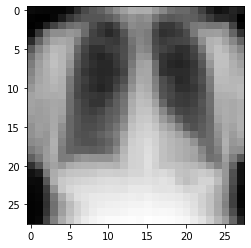

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(chest['train_images'][10], interpolation='nearest')
plt.gray()
plt.show()

### Training Setup

#### Dataset

In [11]:
from PIL import Image

class MyDataset(Dataset):
  def __init__(self, x, y, transform=None, as_rgb=True):
    super().__init__()
    self.x = x
    self.y = y 
    self.transform = transform
    self.as_rgb = as_rgb
  
  def __getitem__(self, idx):
    img, target = self.x[idx], self.y[idx].astype(int)
    img = Image.fromarray(img)
    if self.as_rgb:
        img = img.convert('RGB')

    if self.transform is not None:
        img = self.transform(img)
    
    return img, target

  def __repr__(self):
    return "This is my dataset and it has length {}".format(len(self))

  def __len__(self):
    assert len(self.x) == len(self.y)
    return len(self.y)

#### Route 1: Resize image to `3*224*224` [TRAINED THIS MODEL]

In [12]:
data_transform = transforms.Compose(
    [transforms.Resize((224, 224), interpolation=Image.NEAREST), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])])

my_dataset = MyDataset(chest['train_images'], chest['train_labels'], transform=data_transform)
my_dataloader = DataLoader(my_dataset, batch_size=128, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [13]:
val_dataset = MyDataset(chest['val_images'], chest['val_labels'], transform=data_transform)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = MyDataset(chest['test_images'], chest['test_labels'], transform=data_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

label_mapping = ['atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass', 'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema', 'emphysema', 'fibrosis', 'pleural', 'hernia']

In [14]:
from torchvision.models import resnet18
net = resnet18(pretrained=False, num_classes=14)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [15]:
model_path = "/chestMNIST/resnet18_224_3.pth"

In [16]:
net.load_state_dict(torch.load(model_path, map_location='cuda')['net'], strict=True)

<All keys matched successfully>

#### Route 2: Load modified model

In [17]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])])

my_dataset = MyDataset(chest['train_images'], chest['train_labels'], transform=data_transform, as_rgb=True)
my_dataloader = DataLoader(my_dataset, batch_size=128)

In [18]:
val_dataset = MyDataset(chest['val_images'], chest['val_labels'], transform=data_transform)
val_dataloader = DataLoader(val_dataset, batch_size=128)

test_dataset = MyDataset(chest['test_images'], chest['test_labels'], transform=data_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128)

label_mapping = ['atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass', 'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema', 'emphysema', 'fibrosis', 'pleural', 'hernia']

In [19]:
import sys
sys.path.insert(0, '/chestMNIST')
from models import ResNet18
net = ResNet18(in_channels=3, num_classes=14)

#### Hyperparameters and Testing Loop

In [20]:
num_epochs = 100
lr = 0.001
gamma=0.1
milestones = [0.5 * num_epochs, 0.75 * num_epochs]

# Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# Loss function (cross entropy for classification)
loss_func = nn.BCEWithLogitsLoss()

In [21]:
def getAUC(y_true, y_score):
    '''AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    '''
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    auc = 0
    for i in range(y_score.shape[1]):
        label_auc = roc_auc_score(y_true[:, i], y_score[:, i])
        auc += label_auc
    ret = auc / y_score.shape[1]

    return ret

In [22]:
def getACC(y_true, y_score, threshold=0.5):
    '''Accuracy metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    :param threshold: the threshold for multilabel and binary-class tasks
    '''
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    y_pre = y_score > threshold
    acc = 0
    for label in range(y_true.shape[1]):
        label_acc = accuracy_score(y_true[:, label], y_pre[:, label])
        acc += label_acc
    ret = acc / y_true.shape[1]

    return ret

In [23]:
from sklearn.metrics import roc_auc_score, accuracy_score
def test(model, split_labels, data_loader, criterion, device='cuda', raw=False):
    model.cuda()
    model.eval()
    
    total_loss = []
    y_score = torch.tensor([]).to('cpu')
    with torch.no_grad():
        for batch in data_loader:
            # Forward pass 
            inp, labels = batch
            inp = torch.tensor(inp.cuda(), dtype=torch.float32)
            out = model(inp)
            labels = labels.to(torch.float32).cuda()
            loss = criterion(out, labels)

            # Get predictions from scores
            sigmoid = torch.nn.Sigmoid()
            answers = sigmoid(out).data.cpu()

            # Recording values
            y_score = torch.cat((y_score, answers), 0)
            total_loss.append(loss.item())
        
        y_score = y_score.cpu().data.numpy()
        auc = getAUC(split_labels, y_score)
        acc = getACC(split_labels, y_score)

        testing_loss = np.mean(total_loss)

        if raw:
            return [testing_loss, auc, acc, split_labels, y_score]

        return [testing_loss, auc, acc]

### Training Loop

In [25]:
net.cuda()

best_epoch = 0
best_auc = 0
best_model = net

for epoch in range(num_epochs): # We go over the data ten times
    losses = []
    net.train()
    for batch in my_dataloader:
        optimizer.zero_grad()

        # Forward pass 
        inp, labels = batch
        inp = torch.tensor(inp.cuda(), dtype=torch.float32)
        out = net(inp)
        labels = labels.to(torch.float32).cuda()
        loss = loss_func(out, labels)
        losses.append(loss.item())

        # Backward pass
        loss.backward()
        optimizer.step()
    
    train_loss = np.mean(losses)
    val_metrics = test(net, chest['val_labels'], val_dataloader, loss_func)

    cur_auc = val_metrics[1]
    if cur_auc > best_auc:
        best_epoch = epoch
        best_auc = cur_auc
        best_model = net
        print(f"Epoch {best_epoch} is the best yet with Val AUC = {best_auc}")
        torch.save(best_model, '/content/drive/Shareddrives/AI4ALL_Medical_AI_Notebooks/chest_resnet18_224.pt')
    
    scheduler.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Epoch 0 is the best yet with Val AUC = 0.7131024334298806


OSError: ignored

In [ ]:
torch.save(net, 'chestMNIST/net4.pt')

### Metrics

In [ ]:
from sklearn.metrics import *

In [ ]:
test_metrics = test(net, chest['test_labels'], test_dataloader, loss_func, raw=True)

In [ ]:
y_true, y_score = test_metrics[-2], test_metrics[-1]
print(f"Test AUC: {test_metrics[1]:5f} \nTest ACC: {test_metrics[2]:5f}")

Test AUC: 0.772255 
Test ACC: 0.947303


In [ ]:
y_pre = y_score > 0.5
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pre, average='samples', zero_division=1)
print(f"Test Precision: {precision:.5f}\nTest Recall: {recall:.5f}\nTest F1: {f1:.5f}")

Test Precision: 0.95663
Test Recall: 0.56088
Test F1: 0.54453


This high precision and low recall means that our model predicts many samples as positive – we will have a high number of true positives, but a high number of false positives, too. 

Intuitively, you can think of this as the model casting a wide net to catch a lot of the positive samples, which it does, but it also catches other things too.

We're calculating the above metrics sample-wise, i.e., we compute all three metrics for all samples separately, and returning the sample-weighted average.


We're not calculating the metrics above class-wise, so it makes sense that it won't be similar to class-wise precision-recall-f1 scores computed belowh. I would recommend sticking to the overall accuracies listed above, as they are the most representative.

In [ ]:
for i in range(y_pre.shape[1]):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true[:, i], y_pre[:, i], average='micro', zero_division=1)
    print(f"Class {i}: Precision: {precision:.5f}\tRecall: {recall:.5f}\tF1: {f1:.5f}")

Class 0: Precision: 0.89119	Recall: 0.89119	F1: 0.89119
Class 1: Precision: 0.97441	Recall: 0.97441	F1: 0.97441
Class 2: Precision: 0.88348	Recall: 0.88348	F1: 0.88348
Class 3: Precision: 0.82276	Recall: 0.82276	F1: 0.82276
Class 4: Precision: 0.94758	Recall: 0.94758	F1: 0.94758
Class 5: Precision: 0.94044	Recall: 0.94044	F1: 0.94044
Class 6: Precision: 0.98921	Recall: 0.98921	F1: 0.98921
Class 7: Precision: 0.94945	Recall: 0.94945	F1: 0.94945
Class 8: Precision: 0.95730	Recall: 0.95730	F1: 0.95730
Class 9: Precision: 0.98003	Recall: 0.98003	F1: 0.98003
Class 10: Precision: 0.97718	Recall: 0.97718	F1: 0.97718
Class 11: Precision: 0.98386	Recall: 0.98386	F1: 0.98386
Class 12: Precision: 0.96724	Recall: 0.96724	F1: 0.96724
Class 13: Precision: 0.99813	Recall: 0.99813	F1: 0.99813
0.9473033986919779
0.9473033986919779
0.947303398691978


In [ ]:
multilabel_confusion_matrix(y_true, y_pre, samplewise=False)

array([[[19917,    96],
        [ 2345,    75]],

       [[21794,    57],
        [  517,    65]],

       [[19352,   327],
        [ 2287,   467]],

       [[18199,   296],
        [ 3680,   258]],

       [[21169,   131],
        [ 1045,    88]],

       [[21096,     2],
        [ 1334,     1]],

       [[22191,     0],
        [  242,     0]],

       [[21269,    75],
        [ 1059,    30]],

       [[21475,     1],
        [  957,     0]],

       [[21960,    60],
        [  388,    25]],

       [[21920,     4],
        [  508,     1]],

       [[22071,     0],
        [  362,     0]],

       [[21698,     1],
        [  734,     0]],

       [[22391,     0],
        [   42,     0]]])

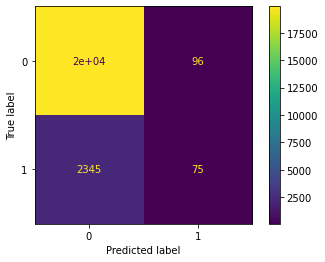

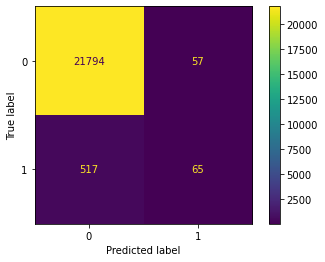

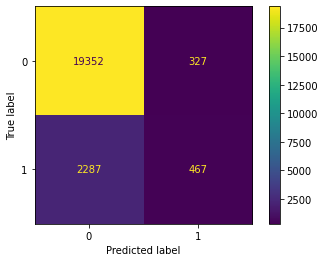

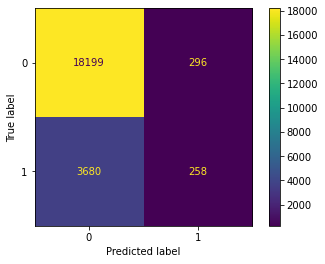

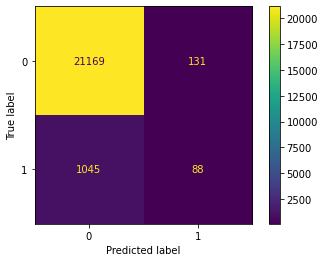

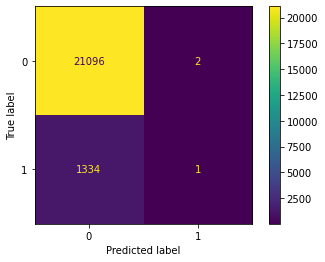

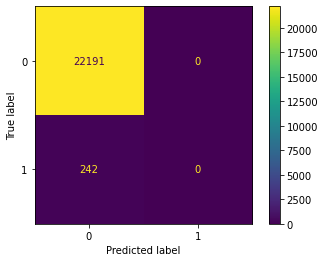

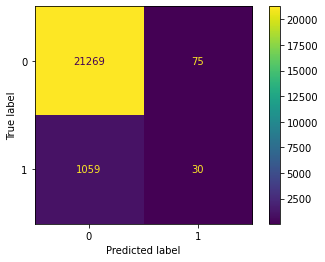

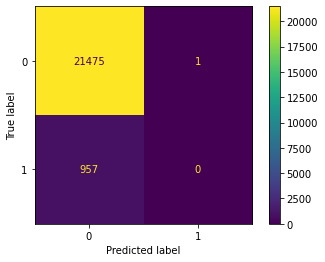

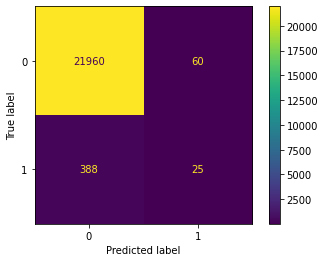

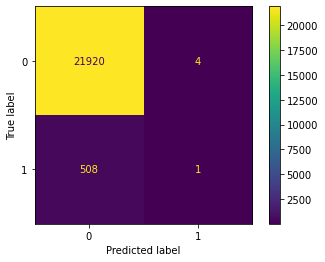

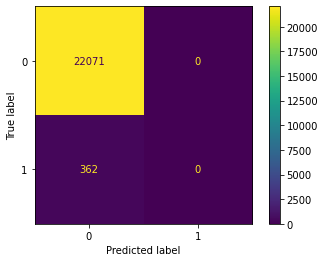

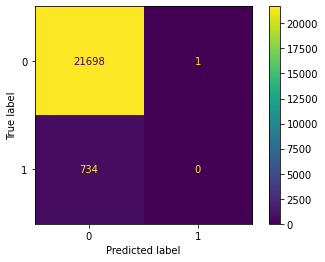

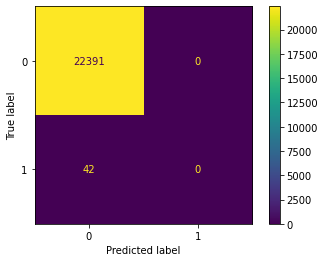

In [ ]:
for i in range(y_score.shape[1]):
    ConfusionMatrixDisplay.from_predictions(y_true[:, i], y_pre[:, i])